<a href="https://colab.research.google.com/github/ayhanardal/spaceship-titanic/blob/main/titanic_spaceship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score, classification_report, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
gsheet_url = 'https://docs.google.com/spreadsheets/d/'
train_url = '1U7YUYM5evnqGHINIIyb-aCYWUWqTVGGaYceBNJvvuTY/export?format=csv'
test_url = '1mUWH3GceYyXVoIYDbn7MyGvhBxelcl-DwWqtXTE0QMs/export?format=csv'

In [ ]:
df = pd.read_csv(gsheet_url + train_url)
test = pd.read_csv(gsheet_url + test_url)
test_df = test.copy()
abt = df.copy()

In [ ]:
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


# EDA

In [ ]:
# !pip install pandas-profiling

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
# profile_train = ProfileReport(df)
# profile_train

# Preprocessing

In [ ]:
def split_cabin(x):
  if len(str(x).split('/')) < 3:
    return ['Missing','Missing','Missing']
  else:
    return str(x).split('/') 

In [ ]:
def preprocessing(df):
  df['HomePlanet'].fillna('Missing', inplace = True)
  df['CryoSleep'].fillna('Missing', inplace = True)
  df['Destination'].fillna('Missing', inplace = True)
  df['VIP'].fillna('Missing', inplace = True)

  df['TempCabin'] = df['Cabin'].apply(lambda x: split_cabin(x))
  df['Deck'] = df['TempCabin'].apply(lambda x: x[0])
  df['Side'] = df['TempCabin'].apply(lambda x: x[2])
  df.drop(['TempCabin','Cabin'],axis=1,inplace=True)



  df['RoomService'].fillna(0, inplace = True)
  df['FoodCourt'].fillna(0, inplace = True)
  df['ShoppingMall'].fillna(0, inplace = True)
  df['Spa'].fillna(0, inplace = True)
  df['VRDeck'].fillna(0, inplace = True)
  df['Age'].fillna(df['Age'].mean(), inplace = True)

  df.drop('Name', axis = 1, inplace=True)

In [ ]:
preprocessing(abt)

In [ ]:
abt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   object 
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   bool   
 12  Deck          8693 non-null   object 
 13  Side          8693 non-null   object 
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
abt = pd.get_dummies(abt, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'])

In [ ]:
abt.columns

Index(['PassengerId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'HomePlanet_Missing', 'CryoSleep_False',
       'CryoSleep_True', 'CryoSleep_Missing', 'Destination_55 Cancri e',
       'Destination_Missing', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True', 'VIP_Missing',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_Missing', 'Deck_T', 'Side_Missing', 'Side_P', 'Side_S'],
      dtype='object')

In [ ]:
abt = abt.drop(['CryoSleep_Missing','HomePlanet_Missing','Destination_Missing','VIP_Missing','Side_Missing','Deck_Missing'],axis = 1)

In [ ]:
abt.head(3)

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0001_01,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0002_01,24.0,109.0,9.0,25.0,549.0,44.0,True,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
abt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                8693 non-null   object 
 1   Age                        8693 non-null   float64
 2   RoomService                8693 non-null   float64
 3   FoodCourt                  8693 non-null   float64
 4   ShoppingMall               8693 non-null   float64
 5   Spa                        8693 non-null   float64
 6   VRDeck                     8693 non-null   float64
 7   Transported                8693 non-null   bool   
 8   HomePlanet_Earth           8693 non-null   uint8  
 9   HomePlanet_Europa          8693 non-null   uint8  
 10  HomePlanet_Mars            8693 non-null   uint8  
 11  CryoSleep_False            8693 non-null   uint8  
 12  CryoSleep_True             8693 non-null   uint8  
 13  Destination_55 Cancri e    8693 non-null   uint8

# Modelling

In [ ]:
X = abt.drop('Transported',axis=1)
y = abt['Transported']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
pipelines = {
    'rf' :  make_pipeline(StandardScaler(),RandomForestClassifier(random_state = 42)),
    'gb' :  make_pipeline(StandardScaler(),GradientBoostingClassifier(random_state = 42))
}

In [ ]:
grid = {
    'rf' : {
        'randomforestclassifier__n_estimators' : [100,200,300]
    },
    'gb' : {
        'gradientboostingclassifier__n_estimators' : [100,200,300]
    }
}

In [ ]:
fit_models = {}
for algo, pipeline in pipelines.items():
  print(f'Traning the {algo} model...')
  model = GridSearchCV(pipeline, grid[algo], n_jobs = -1, cv = 10, scoring = 'accuracy')
  model.fit(X_train,y_train)
  fit_models[algo] = model

Traning the rf model...
Traning the gb model...


# Evelaute Perfonmance on Test Partition


In [ ]:
for algo, model in fit_models.items():
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  print(f'Metric for {algo}: accuracy: {accuracy} precision: {precision} recall: {recall}')

Metric for rf: accuracy: 0.7911683532658693 precision: 0.8043893129770993 recall: 0.771978021978022
Metric for gb: accuracy: 0.7930082796688133 precision: 0.7729591836734694 recall: 0.8324175824175825


# Save Model

In [ ]:
import pickle

In [ ]:
with open('gradientboosted.pkl','wb') as f:
  pickle.dump(fit_models['gb'],f)

In [ ]:
with open('gradientboosted.pkl','rb') as f:
  reloaded_model = pickle.load(f)

In [ ]:
reloaded_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__n_estimators': [100, 200,
                                                                      300]},
             scoring='accuracy')

# Prediction on Test Data

In [ ]:
preprocessing(test_df)
test_df = pd.get_dummies(test_df, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'])
test_df = test_df.drop(['CryoSleep_Missing','HomePlanet_Missing','Destination_Missing','VIP_Missing','Side_Missing','Deck_Missing'],axis = 1)

In [ ]:
y_pred = fit_models['gb'].predict(test_df)

In [ ]:
submission = pd.DataFrame([test_df['PassengerId'],y_pred]).T
submission.columns = ['PassengerId','Transported']
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


<Axes: xlabel='Transported', ylabel='count'>

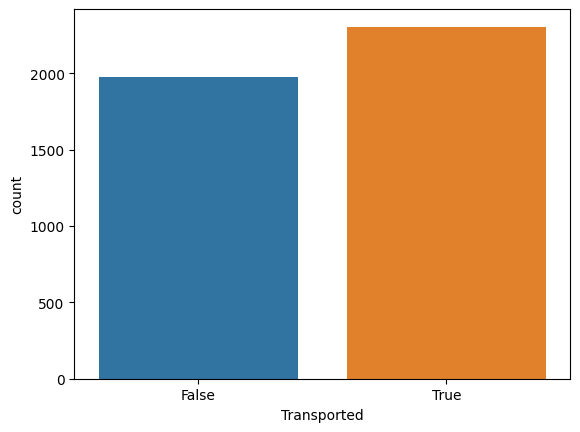

In [ ]:
sns.countplot(data=submission, x = 'Transported')

# Submit Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
submission.to_csv('kaggle_submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c spaceship-titanic -m 'initial model' -f 'kaggle_submission.csv'

100% 56.2k/56.2k [00:00<00:00, 81.1kB/s]
Successfully submitted to Spaceship Titanic